# Original Code and Paper

- Original code(caffe): https://github.com/richzhang/colorization/blob/master/colorization/demo/colorization_demo_v2.ipynb
- Paper: https://arxiv.org/pdf/1603.08511.pdf

# Prepare Model
- You need to download models from Zhang's server
- Run "get_models.sh" to get it

In [40]:
import cv2 # opencv 3.4.2+ required
import os
import numpy as np
import matplotlib.pyplot as plt

In [42]:
proto = './models/colorization_deploy_v2.prototxt'
weights = './models/colorization_release_v2.caffemodel'
# colorization_release_v2_norebal.caffemodel is trained with a classification loss with no class re-balancing term.
# The results are duller but "safer" colorizations
# weights = './models/colorization_release_v2_norebal.caffemodel' 

# load cluster centers
pts_in_hull = np.load('./models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)

# load model
net = cv2.dnn.readNetFromCaffe(proto, weights)
# net.getLayerNames()

# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
# scale layer doesn't look work in OpenCV dnn module, we need to fill 2.606 to conv8_313_rh layer manually
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

# Preprocessing

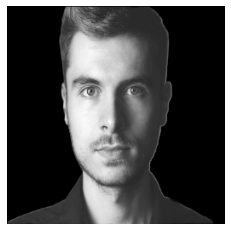

In [50]:
img_path = 'img/Object_image.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_input = img.copy()

# convert BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

img_rgb = img.copy()

# normalize input
img_rgb = (img_rgb / 255.).astype(np.float32)

# convert RGB to LAB
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
# only L channel to be used
img_l = img_lab[:, :, 0]

input_img = cv2.resize(img_l, (256, 256))
input_img -= 50 # subtract 50 for mean-centering

# plot images
# fig = plt.figure(figsize=(10, 5))
# fig.add_subplot(1, 2, 1)
# plt.imshow(img_rgb)
# fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.imshow(input_img, cmap='gray')

# Prediction

True

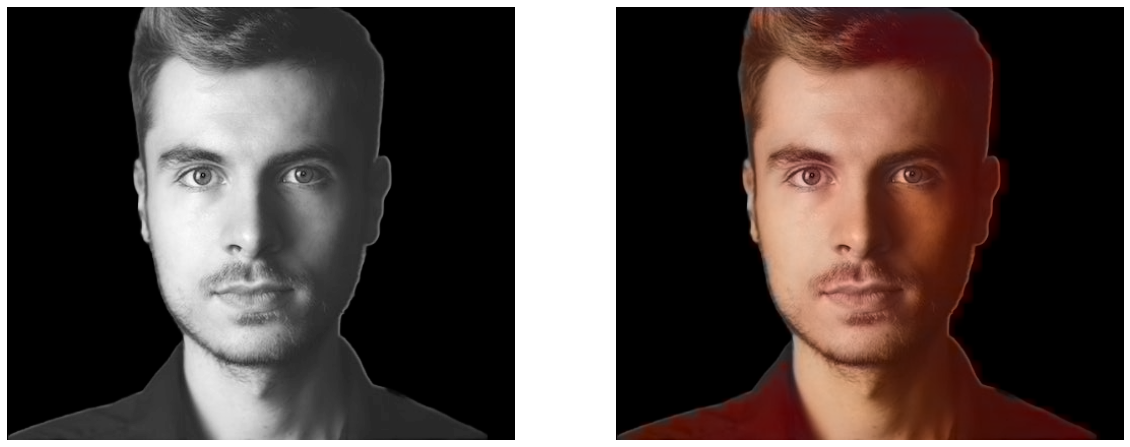

In [49]:
net.setInput(cv2.dnn.blobFromImage(input_img))
pred = net.forward()[0,:,:,:].transpose((1, 2, 0))

# resize to original image shape
pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))

# concatenate with original image L
pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)

# convert LAB to RGB
pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)

# plot prediction result
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(pred_rgb)
# plt.savefig(output_filename)

# save result image file
filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s' % (filename, ext)
output_filename = '%s_output%s' % (filename, ext)

pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename, img_input)
cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))

In [52]:
from keras.models import load_model
from skimage.io import imsave
model = load_model('model.h5')
global color_name
colr_me = []
colr_me.append(img_to_array(load_img(input_img)))
colr_me = np.array(colr_me, dtype=float)
colr_me = rgb2lab(1.0/255*colr_me)[:,:,:,0]
colr_me = colr_me.reshape(colr_me.shape+(1,))
    # Test model
output = model.predict(colr_me)
output = output * 128
    # Output colorizations
for i in range(len(output)):
   cur = np.zeros((256, 256, 3))
   cur[:,:,0] = colr_me[i][:,:,0]
   cur[:,:,1:] = output[i]
   imsave("img2189"+str(i)+".png", lab2rgb(cur))

ImportError: `load_model` requires h5py.